In [105]:
import os
from math import log
from _collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt


In [106]:
SUBJECT_PREFIX = 9
PARTS = 10

MAX_ALP = -5
MIN_ALP = -5
MIN_LB = 0
MAX_LB = 250
LB_STEP = 25
N_GR = 1

In [107]:
ALPHAS = [10 ** x for x in range(MIN_ALP, MAX_ALP + 1)]
LAMBDAS = [10 ** x for x in range(MIN_LB, MAX_LB + 1, LB_STEP)]
SUBJECTS = [0.5, 1.0, 2.0]

In [108]:
ROC_RESOLUTION = 100

In [ ]:
# Создание датасета 
def make_dataset(without, n_gramm):
    
    # Создается три списка
    # Один содержит тренировочную выборку
    # Вторые два - содержимое и тип письма
    train_dataset = []
    test_contents = []
    test_targets  = []
    
    for part in os.listdir("messages"):
        current_dir = "messages/"+part
        
        for file in os.listdir(current_dir):
            source = open(current_dir + '/' + file)
            subject = np.fromiter(source.readline()[SUBJECT_PREFIX:].split(), dtype=int)
            source.readline()
            
            content = nGrammsContent(np.fromiter(source.readline().split(), dtype=int), n_gramm)
            
            letter_type = 0
            if "legit" in file:
                letter_type = 1
                
            if part == without:
                test_contents.append((subject, content))
                #print((subject, content))
                test_targets.append(letter_type)
                source.close()
                continue
            train_dataset.append((letter_type, subject, content))
            source.close()
    return train_dataset, test_contents, test_targets


def nGrammsContent(raw_content, n_gramm):
    new_size = len(raw_content) - n_gramm
    content = list()
    for i in range(new_size):
        bunch = [raw_content[i + j] for j in range(n_gramm)]
        content.append(tuple(bunch))
    return content

In [145]:
def f_m(expected, actual):
    amount = len(expected)
    confusion_matrix = np.zeros((CLASSES_AMOUNT, CLASSES_AMOUNT), dtype=int)
    for letter in range(amount):
        confusion_matrix[actual[letter], expected[letter]] += 1
    tp = 0
    fp = 0
    fn = 0
    for x in range(CLASSES_AMOUNT):
        # Подсчет положительных отмеченных положительно
        tp = tp + confusion_matrix[x, x]
        # Подсчет отрицательных отмеченных положительно
        fp = fp + np.sum(confusion_matrix[x, :]) - confusion_matrix[x, x]
        # Подсчет положительных отмеченных отрицательно
        fn = fn + np.sum(confusion_matrix[:, x]) - confusion_matrix[x, x]
        
    # Полнота
    #           TP
    # TPR = -----------
    #           P
    recall    =  tp / (tp + fn)
    
    # Точность
    #           TP
    # TPR = -----------
    #         TP + FP     
    precision = tp / (tp + fp)
    
    
    #            Precision * Recall
    # F = 2 * ------------------------
    #           Precision + Recall
    f = 2 * (precision * recall) / (precision + recall)
    return f , confusion_matrix[0, 1] / amount

In [193]:
def draw_plot(results):
    extracted = list()
    for lambda_ in LAMBDAS:
        for result in results:
            if result.lambda_ratio == lambda_:
                extracted.append((result.lambda_ratio, result.quality_average, result.selection_average * 100))
                break
    extracted.sort(key=lambda x: x[0])
    keys = list(map(lambda x: x[0], extracted))
    f_measures = list(map(lambda x: x[1], extracted))
    fails = list(map(lambda x: x[2], extracted))

    fig, ax1 = plt.subplots(1, 1)
    plt.xscale("log")
    plt.grid(True)
    ax1.plot(keys, f_measures)
    ax1.set_xlabel("Lambda for legit")
    ax1.set_ylabel("f_measure")
    plt.show()


In [2]:
class BayesClassifier:
    def __init__(self, dataset, params):
        self.dataset = dataset
        self.lambdas = [1.0, 1.0 * params.lambda_ratio]
        self.alpha = params.alpha
        self.subject_weight = params.subject_weight
        self.n_gramm = params.n_gramm
        self.calc()

    def calc(self):
        self.frequencies = [defaultdict(float) for i in range(CLASSES_AMOUNT)]
        self.subject_frequencies = [defaultdict(float) for i in range(CLASSES_AMOUNT)]
        words_amount, self.targets = 0, np.zeros(CLASSES_AMOUNT, dtype=float)
        for letter in self.dataset:
            #print(letter)
            typeLet  = letter[0]
            words_amount = words_amount + len(letter[2])
            self.targets[typeLet] += 1
            for word in letter[2]:
                # Частота тип письма-слова
                self.frequencies[typeLet][word] += 1
            for word in letter[1]:
                # Частота слова для теме письма
                self.subject_frequencies[typeLet][word] += 1
        
        # Подсчет частоты встреч слов в
        # разных типах слов
        objects_amount = len(self.dataset)
        for typeLet in range(CLASSES_AMOUNT):
            for word in self.frequencies[typeLet]:
                self.frequencies[typeLet][word] /= words_amount
            self.targets[typeLet] /= objects_amount
        self.alpha = self.alpha / words_amount

    # Процесс классификация отталкиваясь от ранее обученной модели
    # В данной части запускаем выборку на модели
    def classify(self, tests):
        predictions = list()
        for test in tests:
            this_letter = list()
            # a_nb(x) = argmax(ln(lamda_y * ^Pr(y)) + Sum_j=1_n (ln (^pj (з_j|y))))
            for predicting_type in range(CLASSES_AMOUNT):
                # lamda_y * ^Pr(y)
                classifier = log(self.lambdas[predicting_type] * self.targets[predicting_type])
                
                # ln (^pj (з_j|y) + alpha)
                for word in test[1]:
                    classifier += log(self.frequencies[predicting_type][word] + self.alpha)
                for word in test[0]:
                    classifier += self.subject_weight * log(
                        self.subject_frequencies[predicting_type][word] + self.alpha)
                #print(classifier)
                this_letter.append((predicting_type, classifier))
            
            # argmax(y_Y)
            this_letter.sort(key=lambda x: x[1], reverse=True)
            predictions.append(this_letter[0][0])
        return predictions

    def probabilities(self, tests):
        probabilities = list()
        for test in tests:
            positive_classifier = log(self.lambdas[1] * self.targets[1])
            negative_classifier = log(self.lambdas[0] * self.targets[0])
            for word in test[1]:
                positive_classifier += log(self.frequencies[1][word] + self.alpha)
                negative_classifier += log(self.frequencies[0][word] + self.alpha)
            for word in test[0]:
                positive_classifier += self.subject_weight * log(
                    self.subject_frequencies[1][word] + self.alpha)
                negative_classifier += self.subject_weight * log(
                    self.subject_frequencies[0][word] + self.alpha)
            if positive_classifier > 0 and negative_classifier > 0:
                probabilities.append(positive_classifier / negative_classifier)
            else:
                probabilities.append(negative_classifier / positive_classifier)
        return probabilities

In [182]:
def roc(params):
    probabilities = []
    POSITIVE =  1
    # Повторно обучаем модель
    for part in range(1, PARTS + 1):
        train, test, targets = make_dataset("part" + str(part), params.n_gramm)
        classifier = BayesClassifier(train, params)
        probabilities.extend(zip(classifier.probabilities(test), targets))
        
    # Определение максимальных и минимальных параметров
    min_param = min(probabilities, key=lambda x: x[0])
    max_param = max(probabilities, key=lambda x: x[0])
    
    
    threshold = min_param[0]
    stepper = (max_param[0] - min_param[0]) / ROC_RESOLUTION
    positives = len(list(filter(lambda x: x[1] == POSITIVE, probabilities)))
    tpr, fpr = list(), list()
    total = len(probabilities)
    negatives = total - positives
    while threshold <= max_param[0]:
        above_threshold = list(filter(lambda x: x[0] >= threshold, probabilities))
        tp = len(list(filter(lambda x: x[1] == POSITIVE, above_threshold)))
        tpr.append(tp / positives)
        fpr.append((len(above_threshold) - tp) / negatives)
        threshold = threshold + stepper

    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.title("ROC-Curve for lambda power = %s" % log(params.lambda_ratio, 10))
    plt.grid(True)
    plt.plot(fpr, tpr, 'r')
    plt.show()


In [172]:
class HyperParams:
    def __init__(self, alpha, lambda_ratio, subject_weight, n_gramm):
        self.alpha = alpha
        self.lambda_ratio = lambda_ratio
        self.subject_weight = subject_weight
        self.n_gramm = n_gramm
        self.quality_average = 0.0
        self.selection_average = 0.0

    def put_result(self, quality_average, selection_average):
        self.quality_average = quality_average
        self.selection_average = selection_average

    def __str__(self):
        return "\n f_measure: " + str(self.quality_average) + \
               "\n leg_class_as_spam: " + str((self.selection_average * 100)) + \
               "\n alpha: " + str(self.alpha) + \
               "\n lambda:" + str(shorter(self.lambda_ratio)) + \
               "\n subject weight: " + str(self.subject_weight) + \
               "\n n-gramm: " + str(self.n_gramm)

In [123]:
def shorter(a):
    b=-1
    while a>=1:
        b=b+1
        a=a/10
    return b
    

In [165]:
gen_qual = list()
print("-> Begining of the computation")

# Займемся перебором параметров
# Штраф - ошибки классификации
# Альфа - параметр сглаживания
# Веса объектов
for lambda_ratio in LAMBDAS:
    for alpha in ALPHAS:
        for sub_w in SUBJECTS:
            for n_gramm in range(1, N_GR + 1):
                params = HyperParams(alpha, lambda_ratio, sub_w, n_gramm)
                
                
                print("alpha "+str(alpha)+" lambda 10^"+str(shorter(lambda_ratio))+
                      " sub_w "+str(sub_w)+" n-gramm "+str(n_gramm))
                
                
                lambdas = [1.0, lambda_ratio]
                local_quality = list()
                for part in range(1, PARTS + 1):
                    # Делаем датасет и объект обучения
                    tr, test, targets = make_dataset("part" + str(part), n_gramm)
                    
                    # Осуществляем предсказание
                    predictions = BayesClassifier(tr, params).classify(test)
                    
                    # Оцениваем качество предсказания
                    # Выдает f-меру
                    fmr, spam_am = f_m(targets, predictions)
                    local_quality.append((fmr, spam_am))
                    
                
                qual   = np.average(np.fromiter(map(lambda x: x[0], local_quality), dtype=float))
                select = np.average(np.fromiter(map(lambda x: x[1], local_quality), dtype=float))
                
                print(qual)
                params.put_result(qual, select)
                gen_qual.append(params)
                

print("-> End of computation")

-> Begining of the computation
alpha 1e-05 lambda 10^0 sub_w 0.5 n-gramm 1
0.9801588388333562
alpha 1e-05 lambda 10^0 sub_w 1.0 n-gramm 1
0.9819937012186774
alpha 1e-05 lambda 10^0 sub_w 2.0 n-gramm 1
0.9819937012186774
alpha 1e-05 lambda 10^25 sub_w 0.5 n-gramm 1
0.9590579214021634
alpha 1e-05 lambda 10^25 sub_w 1.0 n-gramm 1
0.9654799397507874
alpha 1e-05 lambda 10^25 sub_w 2.0 n-gramm 1
0.9709845269067507
alpha 1e-05 lambda 10^50 sub_w 0.5 n-gramm 1
0.9193755990688759
alpha 1e-05 lambda 10^50 sub_w 1.0 n-gramm 1
0.9267150486101601
alpha 1e-05 lambda 10^50 sub_w 2.0 n-gramm 1
0.9382993290428592
alpha 1e-05 lambda 10^74 sub_w 0.5 n-gramm 1
0.877858414350267
alpha 1e-05 lambda 10^74 sub_w 1.0 n-gramm 1
0.9019444064083253
alpha 1e-05 lambda 10^74 sub_w 2.0 n-gramm 1
0.918115842804327
alpha 1e-05 lambda 10^100 sub_w 0.5 n-gramm 1
0.8486101602081335
alpha 1e-05 lambda 10^100 sub_w 1.0 n-gramm 1
0.8577844721347392
alpha 1e-05 lambda 10^100 sub_w 2.0 n-gramm 1
0.877625633301383
alpha 1e-05 

In [166]:
best_legit = min(gen_qual, key=lambda x: x.selection_average)
gen_qual.sort(key=lambda x: x.quality_average, reverse=True)
best_quality = gen_qual[0]

In [167]:
bl = best_legit
bq = best_quality

In [174]:
def params_p (pr):
    return "\n f_measure: " + str(pr.quality_average) + \
               "\n leg_class_as_spam: " + str((pr.selection_average * 100)) + \
               "\n alpha: " + str(pr.alpha) + \
               "\n lambda:" + str(shorter(pr.lambda_ratio)) + \
               "\n subject weight: " + str(pr.subject_weight) + \
               "\n n-gramm: " + str(pr.n_gramm)

In [178]:
print("-> Selection")
print(params_p(best_legit))
print()

print("-> Quality")
print(params_p(best_quality))

-> Selection

 f_measure: 0.7745173216486376
 leg_class_as_spam: 0.0
 alpha: 1e-05
 lambda:175
 subject weight: 0.5
 n-gramm: 1

-> Quality

 f_measure: 0.9819937012186774
 leg_class_as_spam: 0.974941804737779
 alpha: 1e-05
 lambda:0
 subject weight: 1.0
 n-gramm: 1


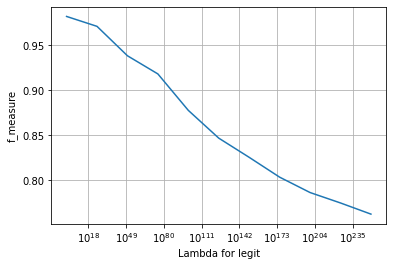

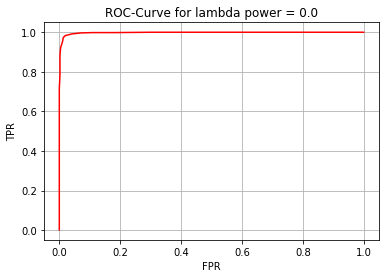

In [195]:
draw_plot(gen_qual)
roc(best_quality)